# Streaming Anomaly and Outlier Detection Methods

In [41]:
from pysad.evaluation import AUROCMetric
from pysad.models import xStream, ExactStorm, HalfSpaceTrees, IForestASD, KitNet, KNNCAD, LODA, LocalOutlierProbability, \
    MedianAbsoluteDeviation, RelativeEntropy, RSHash, RobustRandomCutForest, StandardAbsoluteDeviation
from pysad.transform.preprocessing import InstanceUnitNormScaler
from pysad.transform.probability_calibration import ConformalProbabilityCalibrator
from river import compose
from river import datasets
from river import metrics
from river import preprocessing
from river import anomaly
import dill as pickle

import numpy as np

import matplotlib.pyplot as plt


## Dataset
Run the preprocessing notebook to generate the dataset

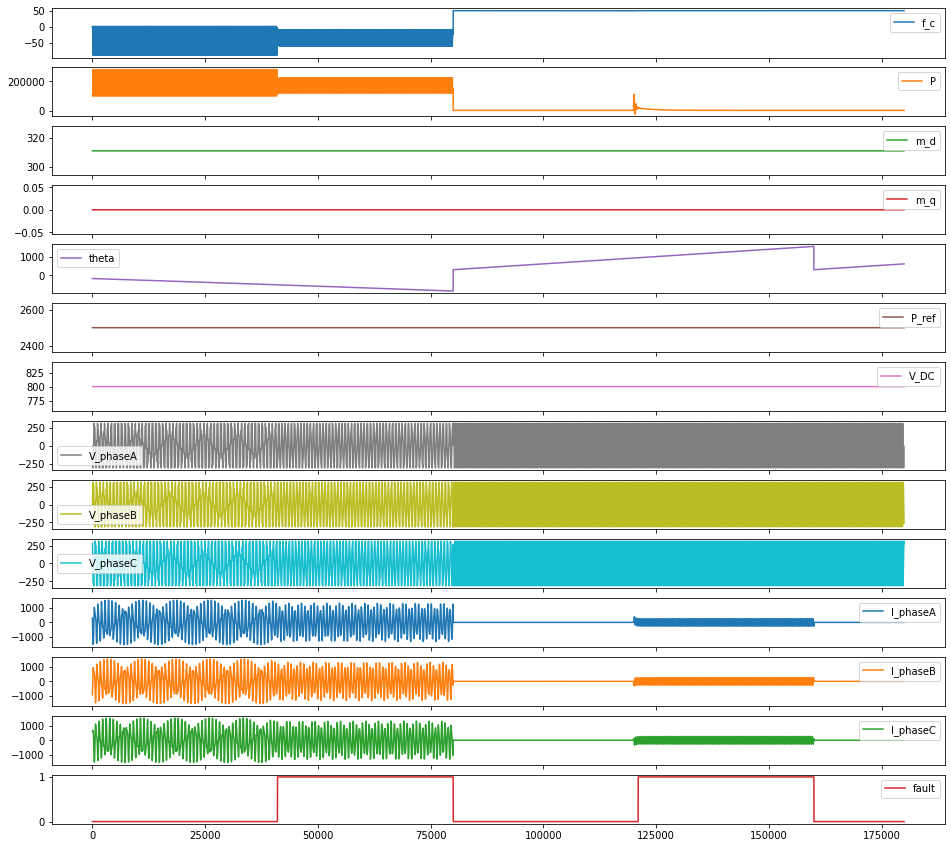

In [2]:
with open('../#datasets/Weak_Grid-7_5_mH.pkl', 'rb') as file:
    df= pickle.load(file)
df = df[:180000].copy()
df.plot(subplots=True, figsize=(16,15));


## River

index: 0
index: 10000
index: 20000
index: 30000
index: 40000
index: 50000
index: 60000
index: 70000
index: 80000
index: 90000
index: 100000
index: 110000
index: 120000
index: 130000
index: 140000
index: 150000
index: 160000
index: 170000
AUC: ROCAUC: 0.632277


Text(0.5, 1.0, 'Detection Method: River HST')

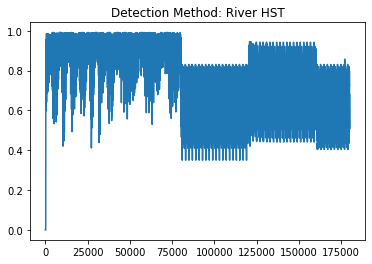

In [3]:
model = compose.Pipeline(
     preprocessing.MinMaxScaler(),
     anomaly.HalfSpaceTrees(seed=42)
 )
hst = anomaly.HalfSpaceTrees(
     n_trees=5,
     height=3,
     window_size=3,
     seed=42
 )
auc = metrics.ROCAUC()

score_list = []
for index, row in df.iterrows():
    features = row.iloc[0:12]
    y = row["fault"]
    hst = model.learn_one(features)
    score = model.score_one(features)
    score_list.append(score)
    auc = auc.update(y, score)
    if index % 10000 == 0:
        print(f"index: {index}")
#     print(f'Anomaly score for x={x:.3f}: {score:.3f}')
print(f'AUC: {auc}')
plt.figure()
plt.plot(score_list)
plt.title("Detection Method: River HST")

## PySad

In [89]:
from sklearn import preprocessing
model_classes = {
        # ExactStorm.__name__: { "model": ExactStorm(),
        #                                "calibrator": ConformalProbabilityCalibrator(windowed=True, window_size=300),
        #                                "count": 0,
        #                                "scores": [],
        #                                 "metric": AUROCMetric()},
        IForestASD.__name__: { "model": xStream(),
                                           "calibrator": ConformalProbabilityCalibrator(windowed=True, window_size=300),
                                           "count": 0,
                                           "scores": [],
                                           "metric": AUROCMetric()},
        # KitNet.__name__: { "model":KitNet(),
        #                                "calibrator": ConformalProbabilityCalibrator(windowed=True, window_size=300),
        #                                "count": 0,
        #                                "scores": [],
        #                                "metric": AUROCMetric()},
        LODA.__name__: { "model":LODA(),
                               "calibrator": ConformalProbabilityCalibrator(windowed=True, window_size=300),
                               "count": 0,
                               "scores": [],
                                "metric": AUROCMetric()},
        # MedianAbsoluteDeviation.__name__: { "model":MedianAbsoluteDeviation(),
        #                        "calibrator": ConformalProbabilityCalibrator(windowed=True, window_size=300),
        #                        "count": 0,
        #                        "scores": [],
        #                         "metric": AUROCMetric()},
        # RelativeEntropy.__name__: { "model":RelativeEntropy(0.0, 1.0),
        #                        "calibrator": ConformalProbabilityCalibrator(windowed=True, window_size=300),
        #                        "count": 0,
        #                        "scores": [],
        #                         "metric": AUROCMetric()},
        RSHash.__name__: { "model":RSHash(feature_mins=[0.0], feature_maxes=[1.0]),
                               "calibrator": ConformalProbabilityCalibrator(windowed=True, window_size=300),
                               "count": 0,
                               "scores": [],
                                "metric": AUROCMetric()},
        # StandardAbsoluteDeviation.__name__: { "model":StandardAbsoluteDeviation(),
        #                            "calibrator": ConformalProbabilityCalibrator(windowed=True, window_size=300),
        #                            "count": 0,
        #                            "scores": [],
        #                             "metric": AUROCMetric()},
        xStream.__name__: {"model": xStream(),
                                       "calibrator": ConformalProbabilityCalibrator(windowed=True, window_size=300),
                                       "count": 0,
                                       "scores": [],
                                        "metric": AUROCMetric()},
        RobustRandomCutForest.__name__: {"model": RobustRandomCutForest(),
                                   "calibrator": ConformalProbabilityCalibrator(windowed=True, window_size=300),
                                   "count": 0,
                                   "scores": [],
                                    "metric": AUROCMetric()},
        # HalfSpaceTrees.__name__: { "model": HalfSpaceTrees([0.0],[1.0]),
        #                            "calibrator": ConformalProbabilityCalibrator(windowed=True, window_size=300),
        #                            "count": 0,
        #                            "scores": [],
        #                             "metric": AUROCMetric()},
    }

In [93]:
print(model_classes.keys())
# print(df.loc[df['fault'] == 1])
pysad_df = df[39800:42200].copy()

for key, props in model_classes.items():
    print(f"Starting running: {key}")

    preprocessor = InstanceUnitNormScaler()  # Init normalizer.
    min_max_scaler = preprocessing.MinMaxScaler()
    for index, row in pysad_df.iterrows():
        x = row.iloc[0:12].values
        x = preprocessor.fit_transform_partial(x)  # Fit preprocessor to and transform the instance.
        x = np.reshape(x, (-1,1))
        x = min_max_scaler.fit_transform(x)
        y = bool(row["fault"])
        anomaly_score = props["model"].fit_score_partial(x,y) # Fit to an instance x and score it.
        if anomaly_score:
            if not isinstance(anomaly_score, list):
                anomaly_score = np.reshape(anomaly_score, (-1,1))
            anomaly_score = props["calibrator"].fit_transform(anomaly_score)
        # print(anomaly_score)
        # print(y)
        props["metric"].update(y, anomaly_score)

        props["scores"].append(anomaly_score)
        # Output if the instance is anomalous.
        if anomaly_score > 0.90:
            props["count"] += 1# If probability of being normal is less than 5%.
            # print(f"Alert: {i}th data point is anomalous.")
        if index % 100 == 0:
            print(f"index: {index}")

    print(f"Finished running: {key}")
print("Done")


dict_keys(['IForestASD', 'LODA', 'RSHash', 'xStream', 'RobustRandomCutForest'])
Starting running: IForestASD
index: 39800
index: 39900
index: 40000
index: 40100
index: 40200
index: 40300
index: 40400
index: 40500
index: 40600
index: 40700
index: 40800
index: 40900
index: 41000
index: 41100
index: 41200
index: 41300
index: 41400
index: 41500
index: 41600
index: 41700
index: 41800
index: 41900
index: 42000
index: 42100
Finished running: IForestASD
Starting running: LODA
index: 39800
index: 39900
index: 40000
index: 40100
index: 40200
index: 40300
index: 40400
index: 40500
index: 40600
index: 40700
index: 40800
index: 40900
index: 41000
index: 41100
index: 41200
index: 41300
index: 41400
index: 41500
index: 41600
index: 41700
index: 41800
index: 41900
index: 42000
index: 42100
Finished running: LODA
Starting running: RSHash
index: 39800
index: 39900
index: 40000
index: 40100
index: 40200
index: 40300
index: 40400
index: 40500
index: 40600
index: 40700
index: 40800
index: 40900
index: 4100

[[0.00308072]
 [1.        ]
 [0.00475288]
 [0.00334433]
 [0.00104585]
 [0.01466707]
 [0.00696761]
 [0.00348159]
 [0.00206167]
 [0.00448974]
 [0.00686295]
 [0.        ]]
IForestASD - ROC: 0.4909651865749427 & Detected Anomalies 210
LODA - ROC: 0.37682926829268293 & Detected Anomalies 0
RSHash - ROC: 0.7009714404836356 & Detected Anomalies 128
xStream - ROC: 0.534683830171635 & Detected Anomalies 237
RobustRandomCutForest - ROC: 0.5386237926481829 & Detected Anomalies 224
River - HST ROCAUC: 0.632277


C:\ProgramData\Anaconda3\envs\FIREMAN-project\lib\site-packages\sklearn\utils\validation.py:673: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.asarray(array, order=order, dtype=dtype)
C:\ProgramData\Anaconda3\envs\FIREMAN-project\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\envs\FIREMAN-project\lib\site-packages\sklearn\utils\validation.py:673: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuple

Text(0.5, 1.0, 'Detection Method: River HST')

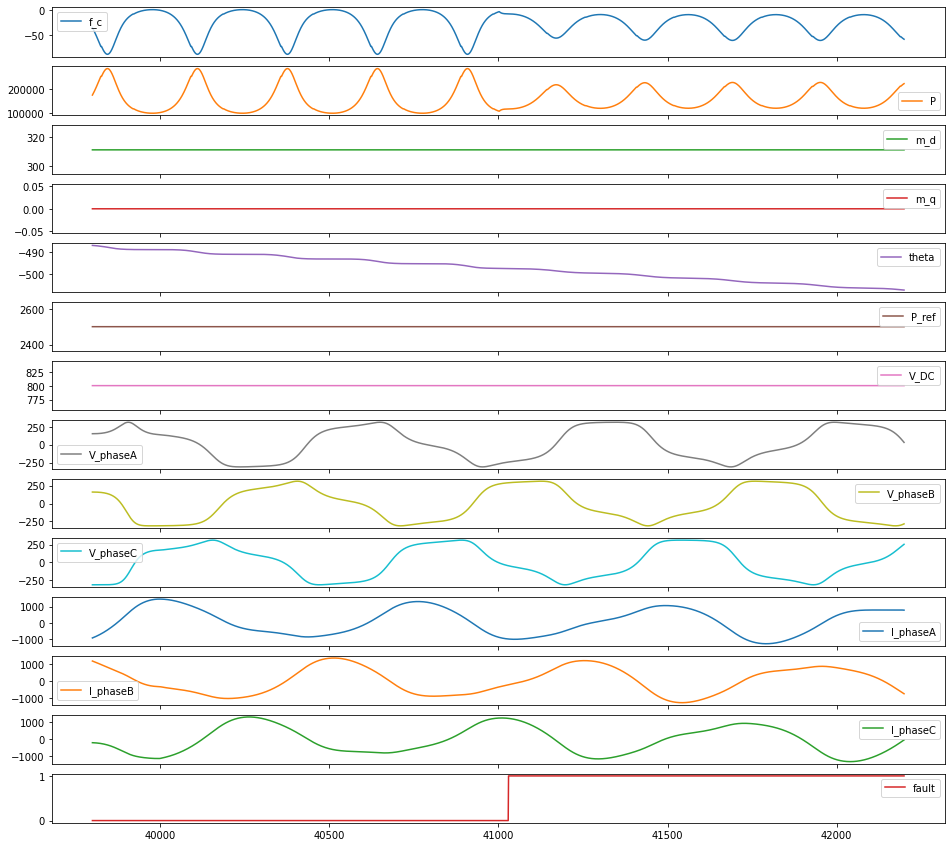

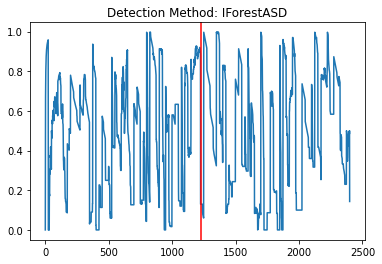

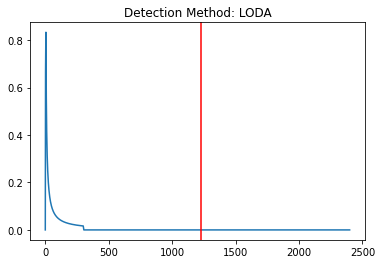

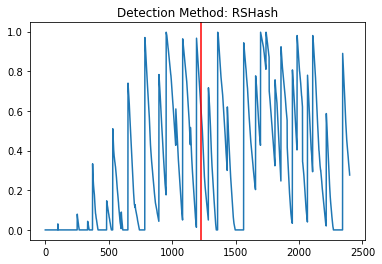

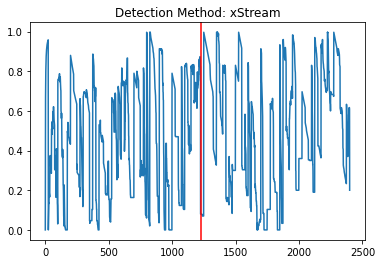

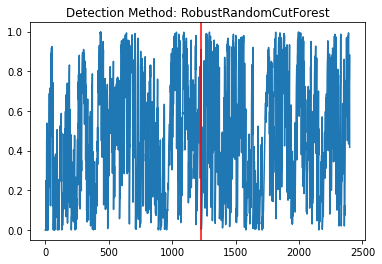

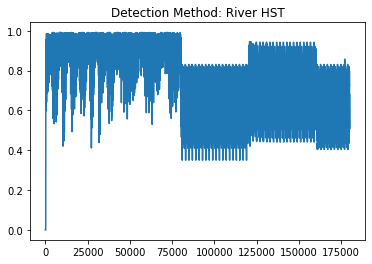

In [95]:
pysad_df.plot(subplots=True, figsize=(16,15));
for key, props in model_classes.items():
    print(f'{key} - ROC: {props["metric"].get()} & Detected Anomalies {props["count"]}')
print(f'River - HST {auc}')
for key, props in model_classes.items():
    plt.figure()
    plt.plot(props["scores"],label=key)
    plt.title(f"Detection Method: {key}")
    plt.axvline(x=41030-39800,color='r')

plt.figure()
plt.plot(score_list)
plt.title("Detection Method: River HST")